In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import io
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time


2.0.0-beta1


In [59]:
# storing all the alphabets of English and the pad char to a dictionary to create OHE representation later.
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
start_char = '<start>'
end_char = '<end>'

eng_alpha2index = {start_char: 0,end_char : 1}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)


# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {start_char: 0,end_char : 1}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'<start>': 0, '<end>': 1, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
{'<start>': 0, '<end>': 1, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '@' + w + '#'
    return w.split()

def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())
    w = w.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in w:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
#     print(cleaned_line)
#     cleaned_line = cleaned_line.split()
#     print(cleaned_line)
    cleaned_line = cleaned_line.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    cleaned_line = '@' + cleaned_line + '#'
    return cleaned_line.split()

In [0]:
import xml.etree.ElementTree as ET
def create_dataset(filename):

    transliterationCorpus = ET.parse(filename).getroot()
    lang1_words = []
    lang2_words = []

    for line in transliterationCorpus:
                wordlist1 = preprocess_sentence_english(line[0].text) # clean English words.
                wordlist2 = preprocess_sentence_hindi(line[1].text)# clean hindi words.
                if len(wordlist1) != len(wordlist2):
                    print('Skipping: ', line[0].text, ' - ', line[1].text)
                    continue

                for word in wordlist1:
                    lang1_words.append(word)
                for word in wordlist2:
                    lang2_words.append(word)
    return [lang1_words,lang2_words]


In [140]:
PATH = "/content/drive/My Drive/NLP-self/Data/English_Devnagri_transliteration_data/"
train_data = create_dataset(PATH+'NEWS2012TrainingEnHi.xml')
test_data = create_dataset(PATH+'NEWS2012-Testing-EnHi-1000.xml')

Skipping:  BUSHNELL'S MUSEUM  -  बुशनेल्स म्युज़ियम
Skipping:  I^DUKAANT  -  इंदुकांत
Skipping:  THE AUSTRALIAN/VOGEL LITERARY AWARD  -  द ऑस्ट्रेलियन/वोगेल लिट्रेरी अवार्ड
Skipping:  Bhaalachan_dr  -  भालचन्द्र
Skipping:  MAN OF THE YEAR/PERSON OF THE YEAR  -  मैन ऑफ द ईयर/पर्सन ऑफ द ईयर
Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  QUEEN ANNE'S WAR  -  क्वीन एनीज वार
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  IN_DRAJEET  -  इन्द्रजीत
Skipping:  SAINT FRANCIS D'ASSISI HIGH SCHOOL  -  सेंट फ्रांसिस ड‍िअस‍ीसी हाई स्कूल
Skipping:  SHU'A  -  शुआ
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  I^diyaa  -  इंडिया
Skipping:  DAI'EI  -  दैई
Skipping:  ISMA'IL  -  इस्मा'ईल
Skipping:  WOMEN'S LITERATURE PRIZE  -  वुमेन्स लिट्रेचर प्राइज़
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  BRAJEN_DR  -  ब्रजेन्द्र
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  LU'LU  -  लु'लु
Skipping:  SAINT MICHAEL'S ACADEMY, CHENNAI  -  सेंट माइकल्स एकेडम

In [141]:
train_data[0][:15],train_data[1][:15]

(['@raasavihaaree#',
  '@deogan',
  'road#',
  '@shatrumardan#',
  '@mahijuba#',
  '@sabine#',
  '@bill',
  'cosby#',
  '@rishta',
  'kagaz',
  'ka#',
  '@hatim#',
  '@shreemayi#',
  '@farihah#',
  '@maritime'],
 ['@रासविहारी#',
  '@दवगन',
  'रोड#',
  '@शतरमरदन#',
  '@महिजबा#',
  '@सबिन#',
  '@बिल',
  'कॉसबी#',
  '@रिशता',
  'कागज',
  'का#',
  '@हातिम#',
  '@शरीमयी#',
  '@फरीहाह#',
  '@मरीटाइम'])

In [142]:
len(test_data[0]),len(test_data[1]),len(train_data[0])

(1000, 1000, 20373)

In [143]:
train_data[0].extend(test_data[0])
train_data[1].extend(test_data[1])

print(len(train_data[0]),len(train_data[1]))

21373 21373


In [144]:
train_data[0][-1],train_data[1][-1]

('@zion#', '@जिऑन#')

In [0]:
# return word_pairs in the form of [English,Hindi]

def add_start_end_char(words):
    res = []
    
    start = '@'
    end = '#'
    for word in words:
      new_word = start+word+end
      res.append(new_word)
      
    return res

In [0]:
train_data = add_start_end_char(train_data[0]),add_start_end_char(train_data[1])
# test_data = add_start_end_char(test_data[0]),add_start_end_char(test_data[1])

In [145]:
len(train_data[0]),len(train_data[1])

(21373, 21373)

In [0]:
class WordIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(num_examples,pairs):


    # index language using the class defined above    
    inp_lang = WordIndex(pairs[0])
    targ_lang = WordIndex(pairs[1])
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en] for en in pairs[0]]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in hn] for hn in pairs[1]]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [0]:
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(num_examples,train_data)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [151]:
convert(inp_lang,input_tensor_train[-1])
convert(targ_lang,target_tensor_train[-1])

3 ----> @
5 ----> b
4 ----> a
7 ----> d
4 ----> a
10 ----> g
4 ----> a
21 ----> r
4 ----> a
1 ----> #
2 ----> @
36 ----> ब
31 ----> द
47 ----> ा
17 ----> ग
40 ----> र
47 ----> ा
1 ----> #


In [152]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(20304, 20304, 1069, 1069)

## Some extra : 

In [0]:
# building corpus

English_corpus = {}
Hindi_corpus = {}

english_alpha = list(eng_alpha2index.keys())
hindi_alpha   = list(hindi_alpha2index.keys())

for en in english_alpha:
  English_corpus[en] = 0

for hn in hindi_alpha:
  Hindi_corpus[hn] = 0

In [0]:
import collections
def build_freq_dict(dictionary,datasets,n_index):
  for data in datasets:
    for dp in data:
      for l in range(len(dp)):
        dictionary[dp[l]]+= 1
  sorted_dict = sorted(dictionary.items(), key=lambda kv: kv[1],reverse = True)
  char_to_freq_count = collections.OrderedDict()
  for pair in sorted_dict:
    char_to_freq_count[pair[0]] = pair[1]
  df_char_freq_rank = pd.DataFrame(index = char_to_freq_count.keys())
  df_char_freq_rank['index'] = range(1,n_index+1)
  df_char_freq_rank['count'] = char_to_freq_count.values()
  
  return df_char_freq_rank


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    """
    Normalizes latin chars with accent to their canonical decomposition
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.strip())
    return w
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())
    return w

In [0]:
# counting the letter freq and storing it in the dictionary
x_train,y_train = train_data[0],train_data[1]
x_test,y_test = test_data[0],test_data[1]

df_char_to_freq_eng = build_freq_dict(English_corpus,[x_train,x_test],27)
df_char_to_freq_hin = build_freq_dict(Hindi_corpus,[y_train,y_test],129)

In [14]:
df_char_to_freq_eng.head()

,index,count
A,1,24237
R,2,10225
I,3,9735
E,4,9462
N,5,9340


In [15]:
df_char_to_freq_hin.head()

,index,count
ा,1,9931
र,2,9892
्,3,8517
न,4,6104
ि,5,5668


In [0]:
def eng_rep(df_char_freq_rank,eng_word):
  rep = []
  for l in eng_word:
    rep.append(df_char_freq_rank['index'][l])
  return rep

def hin_rep(df_char_freq_rank,hn_word):
  rep = []
  for l in hn_word:
    rep.append(df_char_freq_rank['index'][l])
  return rep

In [17]:
eng_rep(df_char_to_freq_eng,x_train[0])

[2, 1, 1, 7, 1, 20, 3, 6, 1, 1, 2, 4, 4]

In [0]:
max_word_len_eng = 20
max_word_len_hn = 21


In [0]:
def word_to_tensor(words,word_rep,max_len,df):
  rep = []
  for word in words:
    word_tensor = word_rep(df,word)

    rep.append(word_tensor)
  pd_tensor = sequence.pad_sequences(rep,maxlen=max_len,padding='post')

  return pd_tensor

In [20]:
word_to_tensor(['HELLO','WORLD'],eng_rep,12,df_char_to_freq_eng)

array([[ 6,  4, 10, 10,  8,  0,  0,  0,  0,  0,  0,  0],
       [22,  8,  2, 10, 11,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [0]:
X_train = word_to_tensor(x_train,eng_rep,max_word_len_eng,df_char_to_freq_eng)
X_test = word_to_tensor(x_test,eng_rep,max_word_len_eng,df_char_to_freq_eng)
Y_train = word_to_tensor(y_train,hin_rep,max_word_len_hn,df_char_to_freq_hin)
Y_test = word_to_tensor(y_test,hin_rep,max_word_len_hn,df_char_to_freq_hin)

## Model trannig

In [0]:
# BUFFER_SIZE = len(X_train)
# BATCH_SIZE = 64
# steps_per_epoch = len(X_train)//BATCH_SIZE
# embedding_dim = 256
# units = 1024
# vocab_inp_size = len(list(eng_alpha2index.keys()))
# vocab_tar_size = len(list(hindi_alpha2index.keys()))

# dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# BUFFER_SIZE = len(input_tensor_train)
# BATCH_SIZE = 64
# N_BATCH = BUFFER_SIZE//BATCH_SIZE
# embedding_dim = 256
# units = 1024
# vocab_inp_size = len(inp_lang.word2idx)
# vocab_tar_size = len(targ_lang.word2idx)

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [155]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 16]))

## New model

In [0]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))


In [161]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

W0817 14:43:50.501907 140431325484928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 14:43:51.809124 140431325484928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [167]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['@']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4s}'.format(epoch + 1,
                                                         batch,
                                                         str(batch_loss)))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss Tens


KeyboardInterrupt: ignored

## Old model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
#     print(type(x))
    x = self.embedding(x)
#     print(x.shape)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [157]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [159]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)


    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [161]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 55)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word2idx['@']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [165]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

W0817 18:06:04.260937 140658811774848 ag_logging.py:145] Entity <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>>: ValueError: Failed to parse source code of <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>>, which Python reported as:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
  def call(self, x, hidden):
#     print(type(x))
    x = self.embedding(x)
#     print(x.shape)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
  def call(self, x, hidden):
#     print(type(x))
    x = self.embedding(x)
#     print(x.shape)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.


W0817 18:06:24.550867 140658811774848 ag_logging.py:145] Entity <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>>: ValueError: Failed to parse source code of <bound method Encoder.call of <__main__.Encoder object at 0x7fecf1307080>>, which Python reported as:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
  def call(self, x, hidden):
#     print(type(x))
    x = self.embedding(x)
#     print(x.shape)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
  def call(self, x, hidden):
#     print(type(x))
    x = self.embedding(x)
#     print(x.shape)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

This may be caused by multiline strings or comments not indented at the same level as the code.
Epoch 1 Batch 0 Loss 1.2760
Epoch 1 Batch 100 Loss 0.8458
Epoch 1 Batch 200 Loss 0.4385
Epoch 1 Batch 300 Loss 0.2282
Epoch 1 Loss 0.6259
Time taken for 1 epoch 122.90636730194092 sec

Epoch 2 Batch 0 Loss 0.2406
Epoch 2 Batch 100 Loss 0.1974
Epoch 2 Batch 200 Loss 0.1945
Epoch 2 Batch 300 Loss 0.1429
Epoch 2 Loss 0.2064
Time taken for 1 epoch 79.23210859298706 sec

Epoch 3 Batch 0 Loss 0.1504
Epoch 3 Batch 100 Loss 0.1558
Epoch 3 Batch 200 Loss 0.1419
Epoch 3 Batch 300 Loss 0.1008
Epoch 3 Loss 0.1463
Time taken for 1 epoch 78.2243857383728 sec

Epoch 4 Batch 0 Loss 0.1240
Epoch 4 Batch 100 Loss 0.1254
Epoch 

In [53]:
inp_lang.word2idx['r']

21

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_english(sentence)[0]

    inputs = [inp_lang.word2idx[i] for i in sentence]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    print(inputs)
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['@']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '#':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
#     print(predicted_sentence)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
#     print(type(result))
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(list(sentence))]
    plot_attention(attention_plot, list(sentence), result.split(' '))

In [118]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

[3, 29, 12, 18, 17, 1]
[[ 3 29 12 18 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Input: @zion#
Predicted translation: ज ि ऑ न # न # न # न # न # न # न 


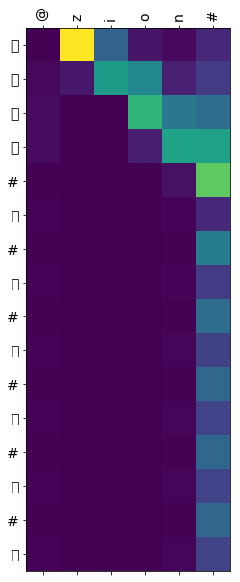

In [166]:
translate('zion')